# Training & Evaluation of Several Filters

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import time
from math import sqrt
from sklearn.externals import joblib

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/nicochaves/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nicochaves/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

## Load Training Data (Chromosome 11)

In [2]:
train_dir = '../data/processed/chrom11/'
train_file = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.11.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels.table'
df_train_full = pd.read_csv(train_dir + train_file, sep='\t')

## Load Test Data (Chromosome 20)

In [3]:
# Load the test data (Chrom 20)
test_dir = '../data/processed/chrom20/'
test_file = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels.table'
df_test = pd.read_csv(test_dir + test_file, sep='\t')

In [4]:
print 'Features (some of these may get taken out): ', df_train_full.columns
print '# training examples: ', df_train_full.shape[0]
print '# test examples: ', df_test.shape[0]

Features (some of these may get taken out):  Index([u'Unnamed: 0', u'QUAL', u'AC', u'AF', u'DP', u'FS', u'MLEAC', u'MLEAF',
       u'MQ', u'QD', u'SOR', u'sample1.DP', u'sample1.GQ',
       u'POSITIVE_TRAIN_SITE', u'DB', u'FILTER', u'GROUND_TRUTH'],
      dtype='object')
# training examples:  187242
# test examples:  86843


In [5]:
df_train_full = df_train_full.drop('Unnamed: 0', axis=1)  
df_test = df_test.drop('Unnamed: 0', axis=1)

#df_train_full = df_train_full.drop(['Unnamed: 0', 'sample1.PL', 'sample1.AD', 'sample1.GT', 'REF', 'ALT', 'ID', 'CHROM', 'POS'], axis=1)

## Split training data into train and test

In [6]:
num_train = df_train_full.shape[0]
idx_train_dev = train_test_split(range(num_train), range(num_train), test_size = 0.3, random_state=0)
idx_train = idx_train_dev[0]
idx_dev = idx_train_dev[1]

In [7]:
df_train = df_train_full.loc[idx_train,:]
df_dev = df_train_full.loc[idx_dev,:]

df_train_Y = df_train['GROUND_TRUTH']
df_train_X = df_train.drop(['GROUND_TRUTH'], axis=1)

df_dev_Y = df_dev['GROUND_TRUTH']
df_dev_X = df_dev.drop(['GROUND_TRUTH'], axis=1)

df_test_Y = df_test['GROUND_TRUTH']
df_test_X = df_test.drop(['GROUND_TRUTH'], axis=1)

df_train_full_Y = df_train_full['GROUND_TRUTH']
df_train_full_X = df_train_full.drop(['GROUND_TRUTH'], axis=1)

In [8]:
def sensitivity_specificity(labels, predictions):
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    return tpr[1], 1-fpr[1]

# Evaluate VQSR Performance

In [9]:
# See https://software.broadinstitute.org/gatk/guide/article?id=39 for interpretation of tranche labels

LOW_QUAL = 'LowQual'
TRANCHE_99_9 = 'VQSRTrancheSNP99.90to100.00' # if you ignore these and the above, you recover at most 99.9% of all variants. has some low vqslod values
TRANCHE_99 = 'VQSRTrancheSNP99.00to99.90' # if you retain these and ignore the above, you'll recover at most 99% of variants. 
PASS_ALL = 'PASS'  # if you **retain** these and ignore the above, you'll recover at most 90% of the variants

def did_variant_pass_filter(label, tranche):
    return label == PASS_ALL or \
            (tranche == TRANCHE_99 and label == TRANCHE_99) or \
            (tranche == TRANCHE_99_9 and (label == TRANCHE_99 or label == TRANCHE_99_9))
            
def convert_vqsr_labels(raw_labels, tranche=None):
    num_labels = raw_labels.shape[0]
    labels = num_labels * [0]
    for i, label in enumerate(raw_labels):
        if did_variant_pass_filter(label, tranche):
            labels[i] = 1
    return labels        

In [10]:
vqsr_dev_labels = df_dev_X['FILTER']
vqsr_test_labels = df_test_X['FILTER']
vqsr_tranches_uniq = set(df_dev_X['FILTER'])

if LOW_QUAL in vqsr_tranches_uniq:
    vqsr_tranches_uniq -= {LOW_QUAL}

vqsr_tranches_uniq = list(vqsr_tranches_uniq)    

vqsr_sens = np.zeros(len(vqsr_tranches_uniq))
vqsr_spec = np.zeros(len(vqsr_tranches_uniq))
vqsr_f1 = np.zeros(len(vqsr_tranches_uniq))

for i, tranche in enumerate(vqsr_tranches_uniq):
    print 'Tranche: ', tranche
    vqsr_dev_labels_binary = convert_vqsr_labels(vqsr_dev_labels, tranche)
    vqsr_dev_acc = accuracy_score(df_dev_Y, vqsr_dev_labels_binary)
    print 'VQSR Dev Accuracy: ', vqsr_dev_acc
    vqsr_test_labels_binary = convert_vqsr_labels(vqsr_test_labels, tranche)
    vqsr_test_acc = accuracy_score(df_test_Y, vqsr_test_labels_binary)
    print 'VQSR Test Accuracy: ', vqsr_test_acc
    
    vqsr_sens[i], vqsr_spec[i] = sensitivity_specificity(df_test_Y, vqsr_test_labels_binary)
    print 'Sensitivity: ', vqsr_sens[i]
    print 'Specificity: ', vqsr_spec[i]
    
    
    vqsr_f1[i] = f1_score(df_test_Y, vqsr_test_labels_binary, average='weighted')  
    print 'F1 score: ', vqsr_f1[i]

Tranche:  VQSRTrancheSNP99.00to99.90
VQSR Dev Accuracy:  0.922898901608
VQSR Test Accuracy:  0.925348041869
Sensitivity:  0.96907173811
Specificity:  0.705109489051
F1 score:  0.923066278292
Tranche:  VQSRTrancheSNP99.90to100.00
VQSR Dev Accuracy:  0.929467893828
VQSR Test Accuracy:  0.837304100503
Sensitivity:  0.98574346518
Specificity:  0.0896072297532
F1 score:  0.784819378897
Tranche:  PASS
VQSR Dev Accuracy:  0.886475708971
VQSR Test Accuracy:  0.919463860069
Sensitivity:  0.922230809572
Specificity:  0.905526590198
F1 score:  0.923450057531


### TODO: Consider using VQSLOD to obtain AUC Score. Issue is that sometimes the VQSLOD is NAN

In [29]:
## Verify that the VQSR tranches worked as expected
file_dir = '../../data/processed/chrom20/'
df2 = pd.read_csv(file_dir + filename + '.table', sep='\t') # training and dev sets combined
df2.columns

NameError: name 'filename' is not defined

In [30]:
df2_pos = df2[df2['POSITIVE_TRAIN_SITE'] == 1]['FILTER']
num_pos_training_sites = df2_pos.shape[0]
print '# of positive training sites used by VQSR: ', num_pos_training_sites

NameError: name 'df2' is not defined

In [31]:
numPass = df2_pos[df2_pos == 'PASS'].shape[0]
num99 = df2_pos[df2_pos == 'VQSRTrancheSNP99.00to99.90'].shape[0]
num99_9 = df2_pos[df2_pos == 'VQSRTrancheSNP99.90to100.00'].shape[0]
numLowQual = df2_pos[df2_pos == 'LowQual'].shape[0]

print '# PASS: ', numPass, ' or ', 100.0*numPass/num_pos_training_sites, '%'
print '# VQSRTrancheSNP99.00to99.90: ', num99, ' or ', 100.0*num99/num_pos_training_sites, '%'
print '# VQSRTrancheSNP99.90to100.0: ', num99_9, ' or ', 100.0*num99_9/num_pos_training_sites, '%'
print '# LowQual: ', numLowQual

NameError: name 'df2_pos' is not defined

In [15]:
96.8750954111+ 2.90660397521

99.78169938631001

### It appears that VQSR rounds the VQSLOD thresholds because these sensitivities are not extremely close to the advertised levels. 

## Remove VQSR Filter label so that we can run non-VQSR methods

In [11]:
df_train_X = df_train_X.drop(['FILTER'], axis=1)
df_dev_X = df_dev_X.drop(['FILTER'], axis=1)
df_train_full_X = df_train_full_X.drop(['FILTER'], axis=1)
df_test_X = df_test_X.drop(['FILTER'], axis=1)

# Supervised Learning Approaches

In [20]:
# Number of folds for cross validation
num_folds = 5 #10

loss_function = 'l2'  # Loss function to use. Must be either 'l1' or 'l2'

## Logistic Regression

In [13]:
lr_start = time.clock()

lr_params = {'C':np.logspace(1, 7, 20)}
lr_obj = linear_model.LogisticRegression(penalty=loss_function, random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
lr_classifier = GridSearchCV(lr_obj, lr_params, cv=num_folds)
lr_classifier.fit(df_train_X, df_train_Y)

lr_stop = time.clock()
lr_time_train = lr_stop - lr_start

print 'Logistic Regression CV Time (in seconds): ', lr_time_train

Logistic Regression CV Time (in seconds):  163.651102


In [16]:
# Save the classifier
joblib.dump(lr_classifier, 'lr_classifier')

['lr_classifier']

In [13]:
# Load the saved classifier
lr_classifier = joblib.load('lr_classifier')

In [22]:
lr_best_est = lr_classifier.best_estimator_
print 'Logistic Regression Best Score: ', lr_classifier.best_score_
print 'Logistic Regression Best Estimator: ', lr_best_est
lr_dev_score = lr_classifier.score(df_dev_X, df_dev_Y)
print 'Logistic Regression Score on Dev Set: ', lr_dev_score

Logistic Regression Best Score:  0.959792170536
Logistic Regression Best Estimator:  LogisticRegression(C=29763.51441631313, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Logistic Regression Score on Dev Set:  0.959713741477


In [ ]:
"""
lr_pred_test = lr_cv_L2.predict(df_test_X)
#conf_lr_cv = lr_cv.decision_function(x_te)
lr_prob_scores_test = lr_cv_L2.predict_proba(df_test_X)
lr_prob_of_pos_test = lr_prob_scores_test[:, 1]

lr_auc_test = roc_auc_score(df_test_Y, lr_prob_of_pos_test)
lr_acc_test = accuracy_score(df_test_Y, lr_pred_test)
print 'AUC: ', lr_auc_test
print 'Accuracy: ', lr_acc_test
"""

## Support Vector Classifier. Train using 5-fold stratified CV with grid search for hyperparameter selection. 

In [14]:
svc_num_folds = 3

svc_start = time.clock()

svc_params = {'C':np.logspace(2, 4, 3), 'gamma':[0.1]}
svc_obj = SVC(kernel='rbf', random_state=0)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
svc_classifier = GridSearchCV(svc_obj, svc_params, cv=svc_num_folds)
svc_classifier.fit(df_train_X, df_train_Y)

svc_stop = time.clock()
svc_time_train = svc_stop - svc_start

print 'SVC CV Time (in seconds): ', svc_time_train

SVC CV Time (in seconds):  2207.209559


In [16]:
# Save the classifier
joblib.dump(svc_classifier, 'svc_classifier')

['svc_classifier']

In [ ]:
# Load the classifier
svc_classifier = joblib.load('svc_classifier')

In [23]:
svc_best_est = svc_classifier.best_estimator_
print 'SVC Best Score: ', svc_classifier.best_score_
print 'SVC Best Estimator: ', svc_best_est
svc_dev_score = svc_classifier.score(df_dev_X, df_dev_Y)
print 'SVC Score on Dev Set: ', svc_dev_score

SVC Best Score:  0.962393853619
SVC Best Estimator:  SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVC Score on Dev Set:  0.962526480694


## Random Forest Classifier. Train using 5-fold stratified CV with grid search for hyperparameter selection. 

In [17]:
num_features = df_train_X.shape[1]

rf_start = time.clock()

# Use 20 trees in the forest (if you have the time or resources, consider using more trees)
# However, I've tried up to 50 trees and it makes very little difference on dev set error
rf_params = {"n_estimators":[20], 
             "criterion": ["gini", "entropy"], 
             "max_features": range(int(sqrt(num_features)),num_features, 2)
            }
rf_obj = RandomForestClassifier(random_state=0)

rf_classifier = GridSearchCV(rf_obj, rf_params, cv=num_folds)
rf_classifier.fit(df_train_X, df_train_Y)

rf_stop = time.clock()
rf_time_train = rf_stop - rf_start

print 'Random Forest CV Time (in seconds): ', rf_time_train

Random Forest CV Time (in seconds):  414.368661


In [19]:
# Save the classifier
joblib.dump(rf_classifier, 'rf_classifier')

['rf_classifier']

In [17]:
rf_classifier = joblib.load('rf_classifier')

In [24]:
rf_best_est = rf_classifier.best_estimator_
print 'Rand Forest Best Score: ', rf_classifier.best_score_
print 'Rand Forest Best Estimator: ', rf_best_est
rf_dev_score = rf_classifier.score(df_dev_X, df_dev_Y)
print 'Rand Forest Score on Dev Set: ', rf_dev_score

Rand Forest Best Score:  0.961951338608
Rand Forest Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Rand Forest Score on Dev Set:  0.962615491428


# Evaluate classifiers on test set. First, we need to retrain classifiers on full dataset using optimal parameters that we found above using cross validation

## Logistic Regression

In [25]:
lr_start = time.clock()

lr_classifier_full = linear_model.LogisticRegression(penalty=loss_function, C=lr_best_est.C)
lr_classifier_full.fit(df_train_full_X, df_train_full_Y) 
lr_pred_test = lr_classifier_full.predict(df_test_X)

lr_stop = time.clock()
lr_time_test = lr_stop - lr_start
print 'Execution Time (in seconds): ', lr_time_test

lr_score_test = lr_classifier_full.score(df_test_X, df_test_Y)
print 'Logistic Regression Test Score: ', lr_score_test

Execution Time (in seconds):  2.096748
Logistic Regression Test Score:  0.947399329825


In [26]:
lr_sens, lr_spec = sensitivity_specificity(df_test_Y, lr_pred_test)
print 'Sensitivity: ', lr_sens
print 'Specificity: ', lr_spec
lr_f1 = f1_score(df_test_Y, lr_pred_test, average='weighted')  
print 'F1 score: ', lr_f1

Sensitivity:  0.987661817881
Specificity:  0.744595064303
F1 score:  0.945081171715


## SVC

In [28]:
svc_sens, svc_spec = sensitivity_specificity(df_test_Y, svc_pred_test)
print 'Sensitivity: ', svc_sens
print 'Specificity: ', svc_spec
svc_f1 = f1_score(df_test_Y, svc_pred_test, average='weighted')  
print 'F1 score: ', svc_f1

Sensitivity:  0.629537111154
Specificity:  0.473826903024
F1 score:  0.652834739782


## Random Forest

In [30]:
rf_start = time.clock()

rf_model_full = RandomForestClassifier(n_estimators=rf_best_est.n_estimators, criterion=rf_best_est.criterion)
rf_model_full.fit(df_train_full_X, df_train_full_Y)
rf_pred_test = rf_model_full.predict(df_test_X)

rf_stop = time.clock()
rf_time_test = rf_stop - rf_start
print 'Execution Time (in seconds): ', rf_time_test

rf_score_test = rf_model_full.score(df_test_X, df_test_Y)
print 'Random Forest Test Score: ', rf_score_test

Execution Time (in seconds):  5.435627
Random Forest Test Score:  0.929009822323


In [31]:
rf_sens, rf_spec = sensitivity_specificity(df_test_Y, rf_pred_test)
print 'Sensitivity: ', rf_sens
print 'Specificity: ', rf_spec
rf_f1 = f1_score(df_test_Y, rf_pred_test, average='weighted')  
print 'F1 score: ', rf_f1

Sensitivity:  0.943553506859
Specificity:  0.855752519986
F1 score:  0.930832611692


# Plot the Results

In [32]:
methods = ['VQSR (99%)', 'VQSR (99.9%)', 'Logisitc Reg', 'SVM', 'Rand Forest']
colors = ['c', 'b', 'r', 'purple', 'g']
vqsr_tranche_idx_99 = vqsr_tranches_uniq.index(PASS_ALL)
vqsr_tranche_idx_99_9 = vqsr_tranches_uniq.index(TRANCHE_99)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

## Plot Sensitivity

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


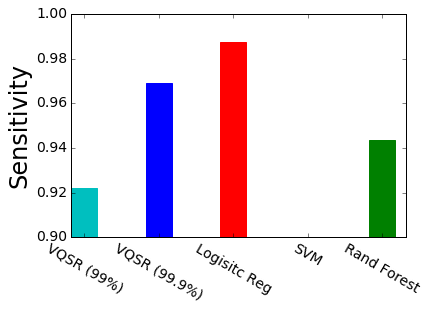

In [33]:
plt.figure()

sensitivities = [vqsr_sens[vqsr_tranche_idx_99], vqsr_sens[vqsr_tranche_idx_99_9], lr_sens, svc_sens, rf_sens]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, sensitivities, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.9, 1.0])
plt.ylabel('Sensitivity', fontsize=24)
plt.show()


## Plot Specificity

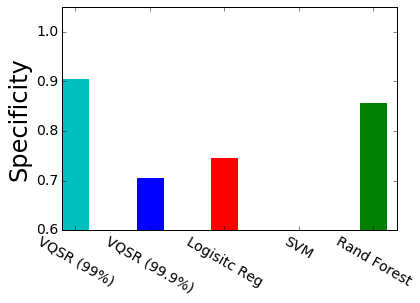

In [34]:
plt.figure()

specificities = [vqsr_spec[vqsr_tranche_idx_99], vqsr_spec[vqsr_tranche_idx_99_9], lr_spec, svc_spec, rf_spec]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, specificities, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods), rotation=-30)

plt.ylim([0.6, 1.05])
plt.ylabel('Specificity', fontsize=24)
plt.show()

## Total Execution Times

In [73]:
lr_total_time = lr_time_train + lr_time_test
svc_total_time = svc_time_train + svc_time_test
rf_total_time = rf_time_train + rf_time_test
print 'Total Execution Times:'
print 'Logistic Reg: ', lr_total_time
print 'SVM: ', svc_total_time
print 'Random Forest: ', rf_total_time

Total Execution Times:
Logistic Reg:  38.116168
SVM:  1446.33854
Random Forest:  134.211096
